# Japanese Equity Data - Feature Engineering

## Imports & Settings

In [1]:
%matplotlib inline

from time import time
import sys, os
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
idx = pd.IndexSlice

## Get Data

### Stooq Japanese Equity data 2014-2019

In [4]:
DATA_DIR = Path('..', 'data')

In [5]:
prices = (pd.read_hdf(DATA_DIR / 'stooq/daily.h5', 'jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2019'], :])

In [6]:
prices.info(null_counts=True)    

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7579096 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7579096 non-null  float64
 1   high    7579096 non-null  float64
 2   low     7579096 non-null  float64
 3   close   7579096 non-null  float64
 4   volume  7579096 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 318.1+ MB


In [7]:
before = len(prices.index.get_level_values('symbol').unique())

### Remove symbols with missing values

In [8]:
prices = (prices.unstack('symbol')
        .sort_index()
        .ffill(limit=5)
        .dropna(axis=1)
        .stack('symbol')
        .swaplevel())
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5642496 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    5642496 non-null  float64
 1   high    5642496 non-null  float64
 2   low     5642496 non-null  float64
 3   close   5642496 non-null  float64
 4   volume  5642496 non-null  float64
dtypes: float64(5)
memory usage: 236.8+ MB


In [9]:
after = len(prices.index.get_level_values('symbol').unique())
print(f'Before: {before:,.0f} after: {after:,.0f}')

Before: 3,706 after: 2,304


### Keep most traded symbols

In [10]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('symbol').median().nlargest(1000).index.tolist()

In [11]:
prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 102.8+ MB


## Feature Engineering

### Compute period returns

In [12]:
intervals = [1, 5, 10, 21, 63]

In [13]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    returns.append(by_sym.pct_change(t).to_frame(f'ret_{t}'))
returns = pd.concat(returns, axis=1)

In [14]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2449000 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ret_1   float64
 1   ret_5   float64
 2   ret_10  float64
 3   ret_21  float64
 4   ret_63  float64
dtypes: float64(5)
memory usage: 102.8+ MB


### Remove outliers

In [15]:
max_ret_by_sym = returns.groupby(level='symbol').max()

In [16]:
percentiles = [0.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles)[6:])

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.170991,0.350070,0.472374,0.626314,1.020888
std,0.082375,0.294864,0.535589,0.818350,1.509939
min,0.066826,0.105313,0.106834,0.130863,0.204481
50%,0.151057,0.253156,0.307139,0.389718,0.638037
90%,0.267628,0.618810,0.848467,1.066849,1.740828
95%,0.340522,0.936015,1.384150,1.688651,2.575133
97.5%,0.377405,1.354108,2.126184,3.103422,4.396535
99%,0.458107,1.668250,3.283605,4.627238,8.028216
99.5%,0.500257,1.958242,3.590269,5.666201,9.627482


In [17]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist()) 

In [18]:
to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.tolist()
len(to_drop)

59

In [19]:
prices = prices.drop(to_drop, level='symbol')
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 96.7+ MB


### Calculate relative return percentiles

In [20]:
returns = []
by_sym = prices.groupby(level='symbol').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='date')
             .apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)

### Technical Indicators

#### Percentage Price Oscillator

In [21]:
ppo = prices.groupby(level='symbol').close.apply(talib.PPO).to_frame('PPO')

#### Normalized Average True Range

In [22]:
natr = prices.groupby(level='symbol', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

#### Relative Strength Indicator

In [23]:
rsi = prices.groupby(level='symbol').close.apply(talib.RSI).to_frame('RSI')

#### Bollinger Bands

In [24]:
def get_bollinger(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u': u, 'm': m, 'l': l})

In [25]:
bbands = prices.groupby(level='symbol').close.apply(get_bollinger)

### Combine Features

In [26]:
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)

In [27]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)

In [28]:
data.bbu.corr(data.bbl, method='spearman')

-0.16180423129450383

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   open             float64
 1   high             float64
 2   low              float64
 3   close            float64
 4   volume           float64
 5   ret_1            float64
 6   ret_rel_perc_1   float64
 7   ret_5            float64
 8   ret_rel_perc_5   float64
 9   ret_10           float64
 10  ret_rel_perc_10  float64
 11  ret_21           float64
 12  ret_rel_perc_21  float64
 13  ret_63           float64
 14  ret_rel_perc_63  float64
 15  PPO              float64
 16  NATR             float64
 17  RSI              float64
 18  bbl              float64
 19  bbu              float64
dtypes: float64(20)
memory usage: 360.5+ MB


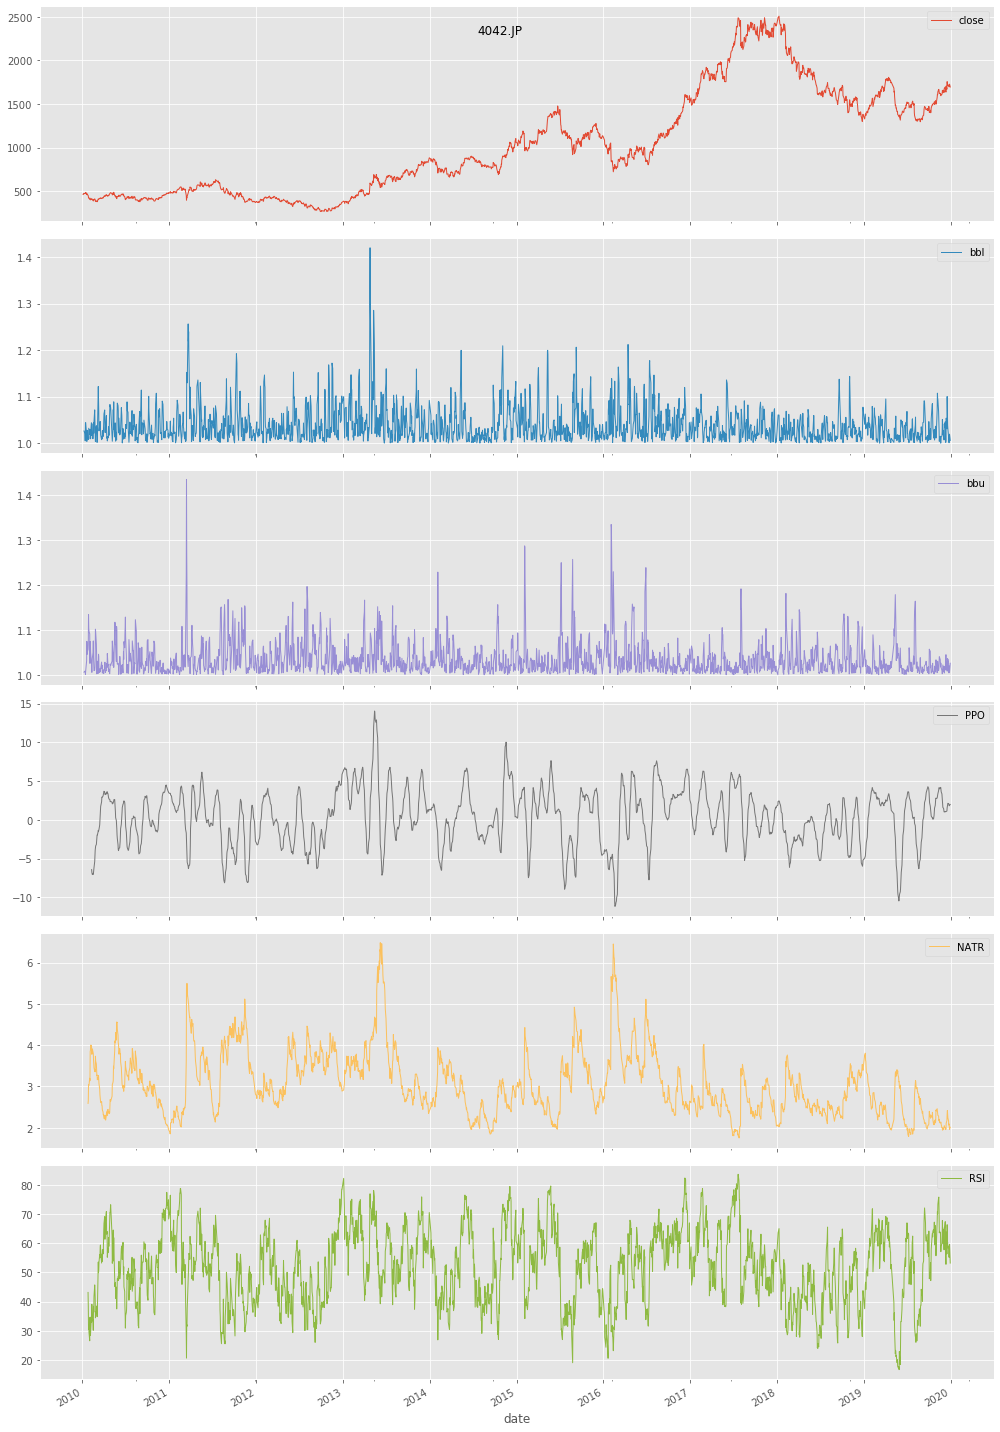

In [30]:
ticker = np.random.choice(data.index.get_level_values('symbol'))
(data.loc[idx[ticker, :], ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']].reset_index('symbol', drop=True)
 .plot(lw=1, subplots=True, figsize=(14, 20), title=ticker))
plt.tight_layout();

In [31]:
data = data.drop(prices.columns, axis=1)

In [32]:
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

## Compute forward returns

In [33]:
with pd.HDFStore('data.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data.h5
/preds_lgb                       frame        (shape->[532040,4])  
/quandl/us/equities              frame        (shape->[171162,61]) 
/stooq/japan/equities            frame        (shape->[1378040,23])


In [34]:
outcomes = []
by_symbol = data.groupby('symbol')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_symbol[f'ret_{t}'].shift(-t)

In [35]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

In [36]:
data.to_hdf('data.h5', 'stooq/japan/equities')